In [ ]:
#Basic libraries
import pandas as pd 
import numpy as np 

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True) 

#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Machine Learning libraries
import sklearn 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
 

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Miscellanous libraries
from collections import Counter

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Deep learning libraries
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#reading the fake and true datasets
fake_news = pd.read_csv('/content/drive/MyDrive/Fake.csv')
true_news = pd.read_csv('/content/drive/MyDrive/True.csv')

# print shape of fake dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(fake_news.shape))
print (fake_news.info())
print("\n --------------------------------------- \n")

# print shape of true dataset with rows and columns and information
print ("The shape of the  data is (row, column):"+ str(true_news.shape))
print (true_news.info())

The shape of the  data is (row, column):(23481, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None

 --------------------------------------- 

The shape of the  data is (row, column):(21417, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


In [ ]:
fake_news.shape
fake_news.drop(fake_news.tail(20500).index,inplace=True)

In [ ]:
fake_news.shape


(2981, 4)

In [ ]:
true_news.shape
true_news.drop(true_news.tail(17000).index,inplace=True)
true_news.shape


(4417, 4)

In [ ]:
#Target variable for fake news
fake_news['output']=0

#Target variable for true news
true_news['output']=1

In [ ]:
#Concatenating and dropping for fake news
fake_news['news']=fake_news['title']+fake_news['text']
fake_news=fake_news.drop(['title', 'text'], axis=1)

#Concatenating and dropping for true news
true_news['news']=true_news['title']+true_news['text']
true_news=true_news.drop(['title', 'text'], axis=1)

#Rearranging the columns
fake_news = fake_news[['subject', 'date', 'news','output']]
true_news = true_news[['subject', 'date', 'news','output']]

In [ ]:
fake_news['date'].value_counts()

July 24, 2017        23
January 25, 2017     23
March 6, 2017        22
May 12, 2017         22
February 2, 2017     21
                     ..
December 4, 2017      1
October 22, 2017      1
November 10, 2017     1
November 12, 2017     1
November 19, 2017     1
Name: date, Length: 342, dtype: int64

In [ ]:
#Removing links and the headline from the date column
fake_news=fake_news[~fake_news.date.str.contains("http")]
fake_news=fake_news[~fake_news.date.str.contains("HOST")]

'''You can also execute the below code to get the result 
which allows only string which has the months and rest are filtered'''
#fake_news=fake_news[fake_news.date.str.contains("Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec")]


'You can also execute the below code to get the result \nwhich allows only string which has the months and rest are filtered'

In [ ]:
#Converting the date to datetime format
fake_news['date'] = pd.to_datetime(fake_news['date'])
true_news['date'] = pd.to_datetime(true_news['date'])

In [ ]:
frames = [fake_news, true_news]
news_dataset = pd.concat(frames)
news_dataset

,subject,date,news,output
0,News,2017-12-31,Donald Trump Sends Out Embarrassing New Year’...,0
1,News,2017-12-31,Drunk Bragging Trump Staffer Started Russian ...,0
2,News,2017-12-30,Sheriff David Clarke Becomes An Internet Joke...,0
3,News,2017-12-29,Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,2017-12-25,Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...,...,...
4412,politicsNews,2017-04-06,Is the sky blue? Depends on what Donald Trump ...,1
4413,politicsNews,2017-04-13,Highlights: The Trump presidency on April 13 a...,1
4414,politicsNews,2017-04-07,Trump taps Lyft executive for transportation p...,1
4415,politicsNews,2017-04-05,"Trump, declining to provide evidence, says thi...",1


In [ ]:
#Creating a copy 
clean_news=news_dataset.copy()

In [ ]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
clean_news['news']=clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news.head()

,subject,date,news,output
0,News,2017-12-31,donald trump sends out embarrassing new year’...,0
1,News,2017-12-31,drunk bragging trump staffer started russian ...,0
2,News,2017-12-30,sheriff david clarke becomes an internet joke...,0
3,News,2017-12-29,trump is so obsessed he even has obama’s name...,0
4,News,2017-12-25,pope francis just called out donald trump dur...,0


In [ ]:
nltk.download('stopwords')
stop = stopwords.words('english')
clean_news['news'] = clean_news['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,subject,date,news,output
0,News,2017-12-31,donald trump sends embarrassing new year’s eve...,0
1,News,2017-12-31,drunk bragging trump staffer started russian c...,0
2,News,2017-12-30,sheriff david clarke becomes internet joke thr...,0
3,News,2017-12-29,trump obsessed even obama’s name coded website...,0
4,News,2017-12-25,pope francis called donald trump christmas spe...,0


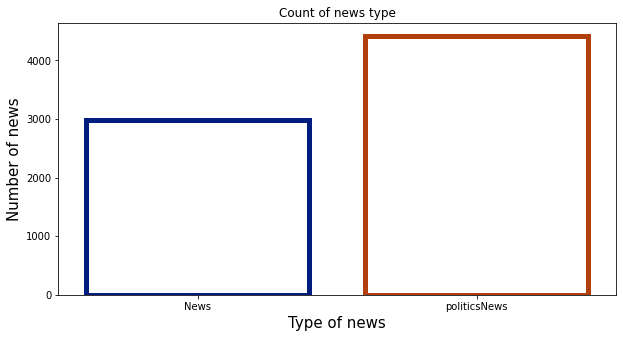

In [ ]:
#Plotting the frequency plot
ax = sns.countplot(x="subject", data=clean_news,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))

#Setting labels and font size
ax.set(xlabel='Type of news', ylabel='Number of news',title='Count of news type')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

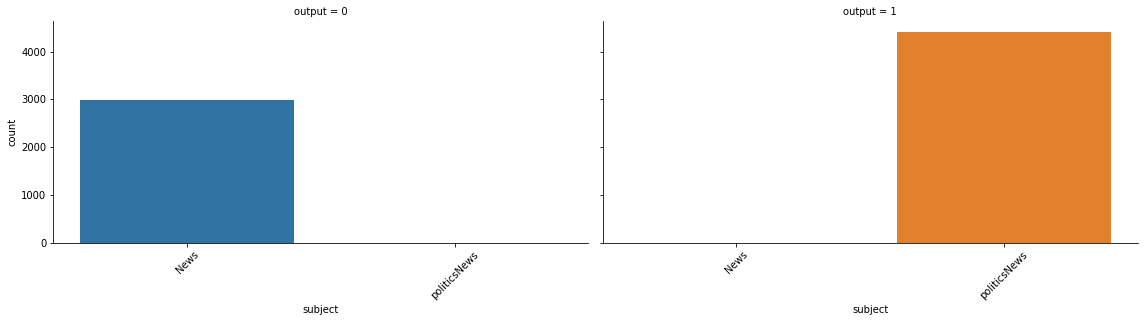

In [ ]:
g = sns.catplot(x="subject", col="output",
                data=clean_news, kind="count",
                height=4, aspect=2)

#Rotating the xlabels
g.set_xticklabels(rotation=45)

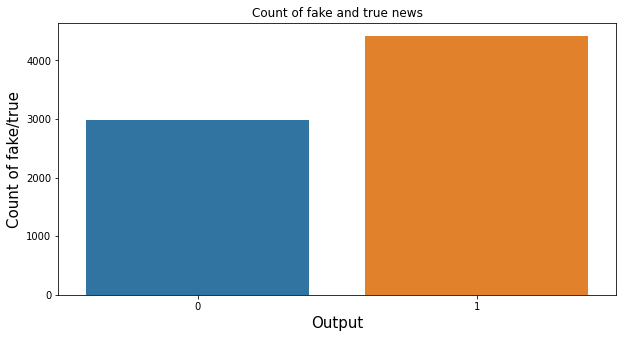

In [ ]:
ax=sns.countplot(x="output", data=clean_news)

#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

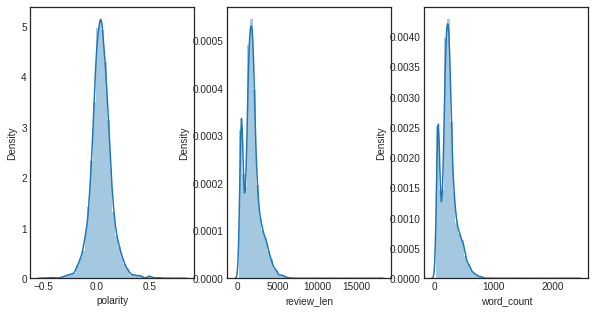

In [ ]:
#Extracting the features from the news
clean_news['polarity'] = clean_news['news'].map(lambda text: TextBlob(text).sentiment.polarity)
clean_news['review_len'] = clean_news['news'].astype(str).apply(len)
clean_news['word_count'] = clean_news['news'].apply(lambda x: len(str(x).split()))
#Plotting the distribution of the extracted feature
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(clean_news['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(clean_news['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(clean_news['word_count'])
fig = plt.gcf()

In [ ]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(clean_news['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df1.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in news')


trump 41589
said 23971
us 15606
president 12453
would 11398
house 10075
donald 7273
white 7025
people 6621
republican 6038
tax 5604
one 5598
senate 5450
also 5389
reuters 5234
states 5165
new 5086
russia 4743
republicans 4702
bill 4679


In [ ]:
#Function to get top bigram words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_bigram(clean_news['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)
    
#Creating the dataframe of word and frequency
df3 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df3.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in news')


donald trump 6801
white house 5725
united states 3704
president donald 3252
image via 2117
trump administration 1892
north korea 1584
trump said 1454
new york 1427
reuters us 1332
us president 1255
house representatives 1065
national security 1036
barack obama 1021
said statement 1000
trump campaign 958
told reporters 943
trump realdonaldtrump 890
attorney general 881
last year 848


In [ ]:
#Function to get top trigram words
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_trigram(clean_news['news'], 20)

#Printing word and their respective frequencies
for word, freq in common_words:
    print(word, freq)

#Creating a dataframe with words and count
df6 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Grouping the words and plotting their frequencies
df6.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in news')


president donald trump 3245
donald trump realdonaldtrump 888
reuters president donald 868
president barack obama 775
affordable care act 466
new york times 442
national security adviser 368
director james comey 360
white house said 353
fbi director james 319
leader mitch mcconnell 303
trump white house 289
speaker paul ryan 282
secretary state rex 278
state rex tillerson 278
special counsel robert 273
counsel robert mueller 273
president mike pence 249
vice president mike 243
donald trump jr 235


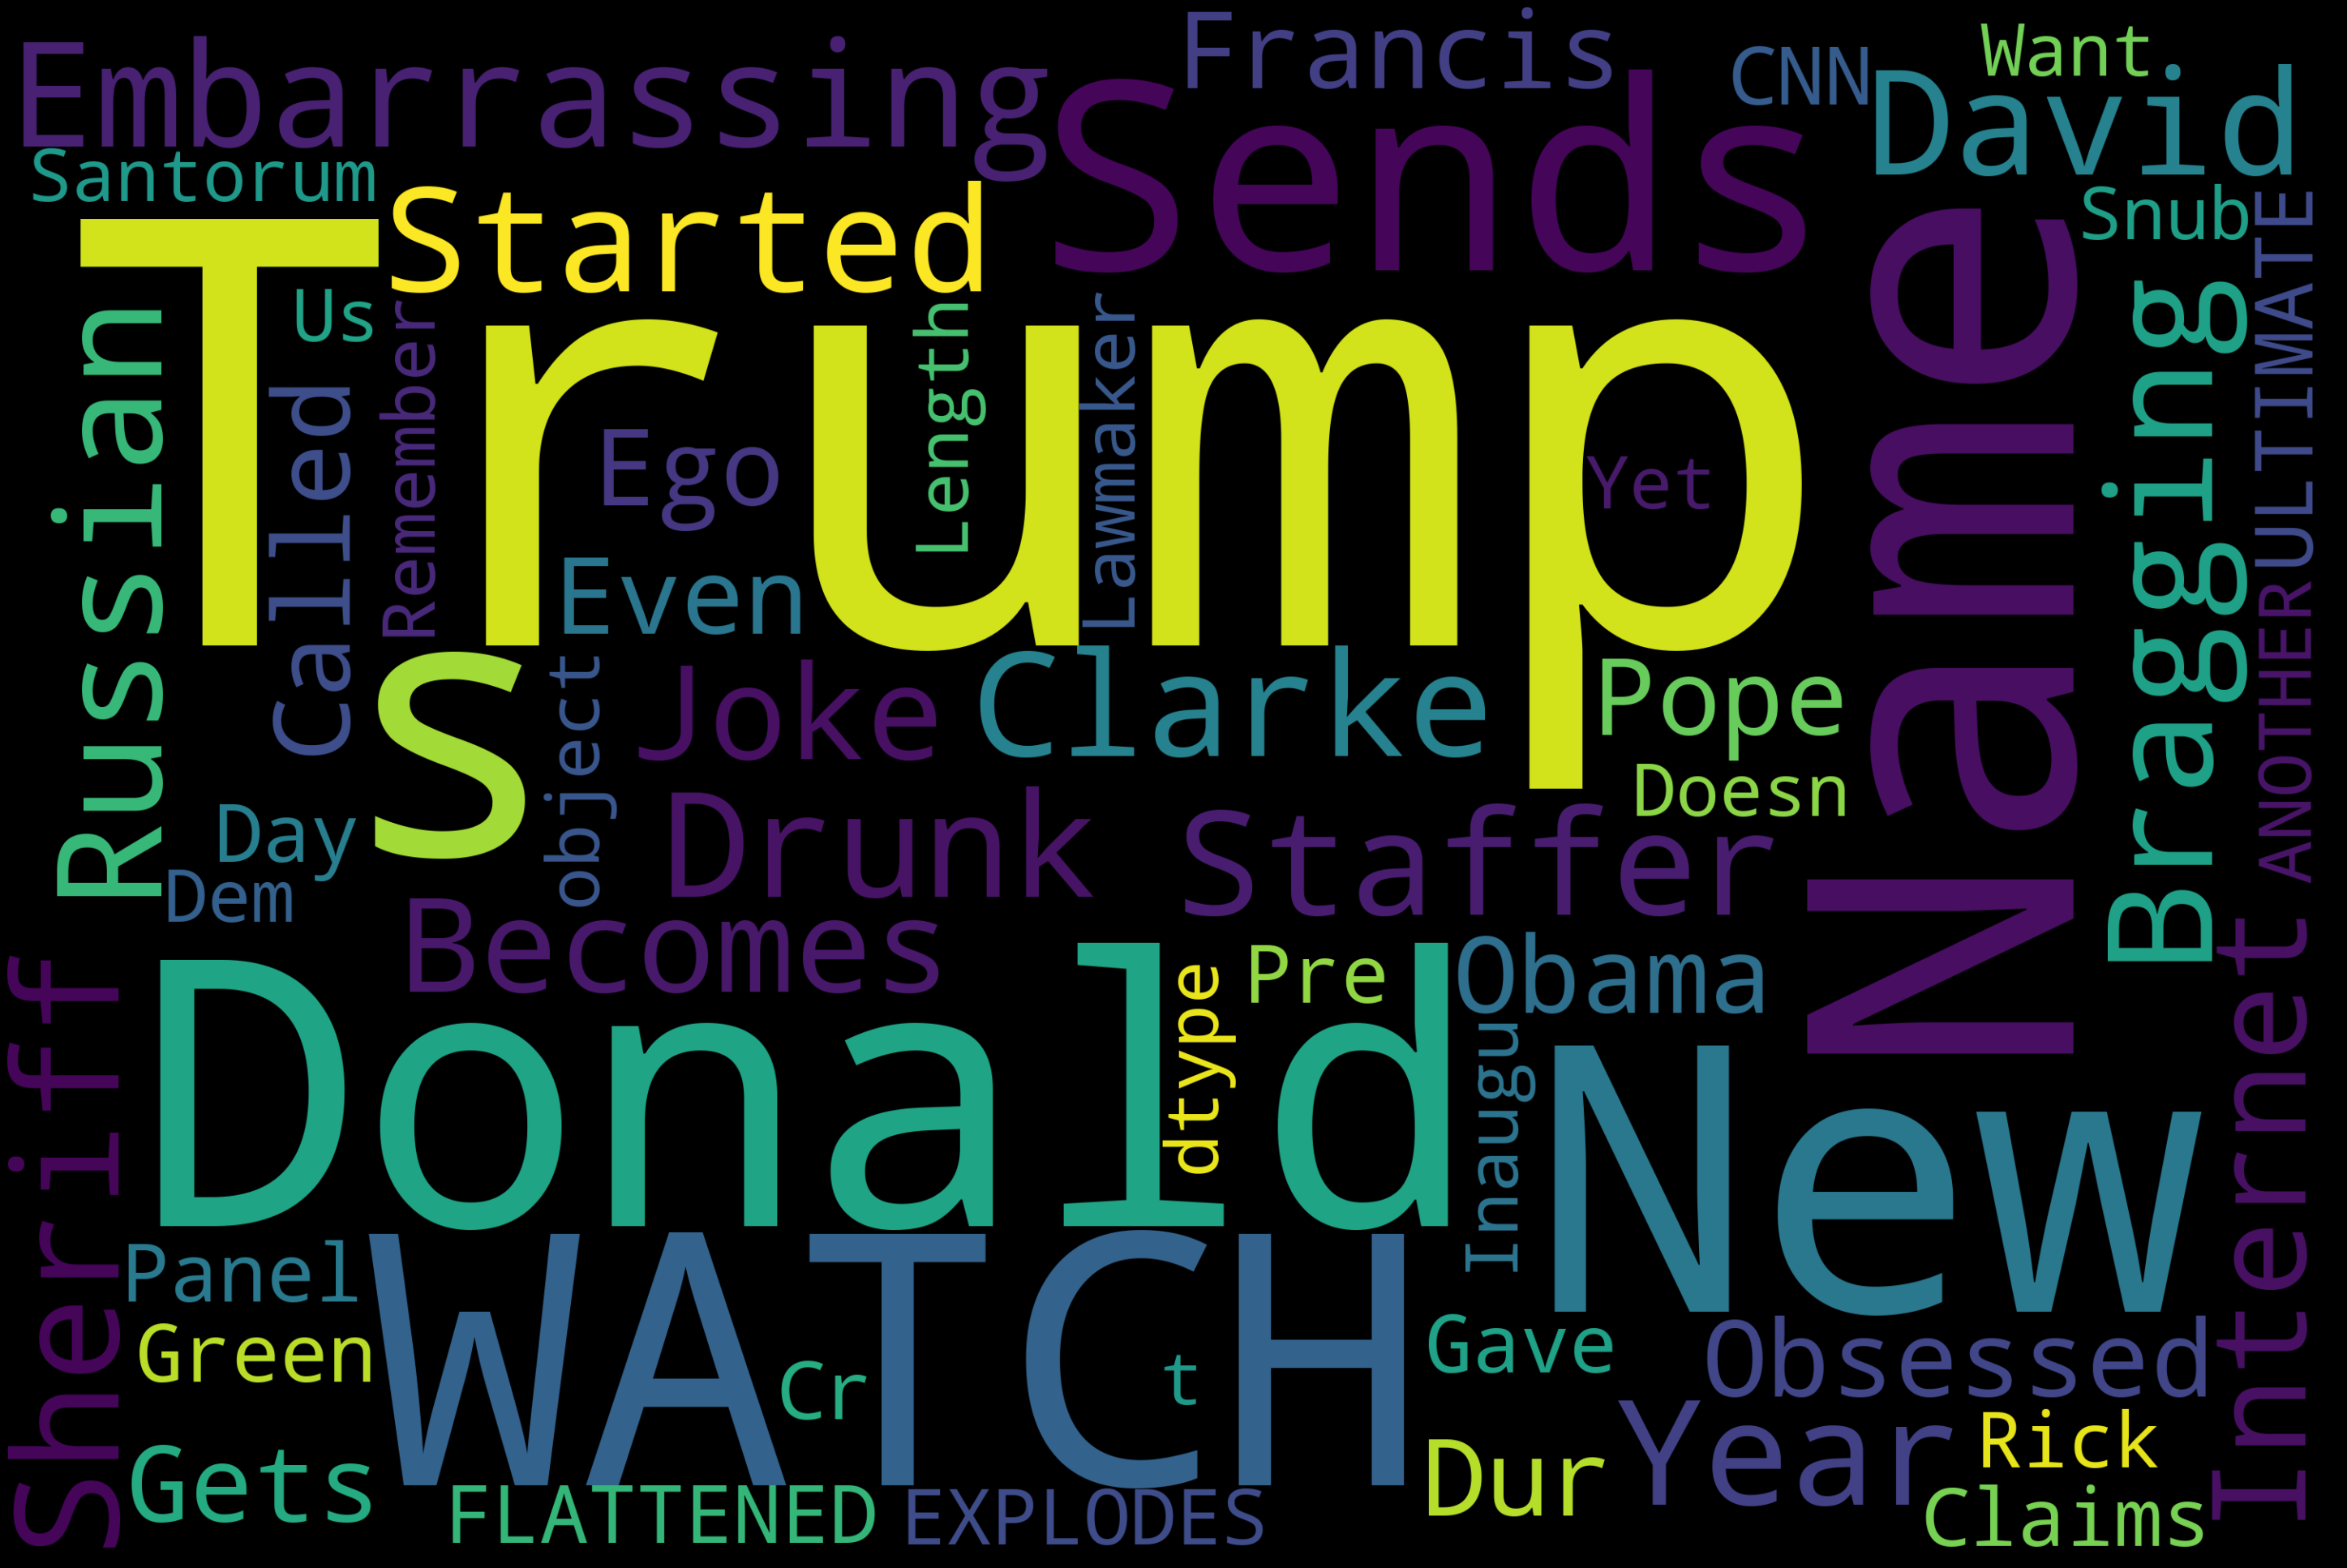

In [ ]:
text = fake_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

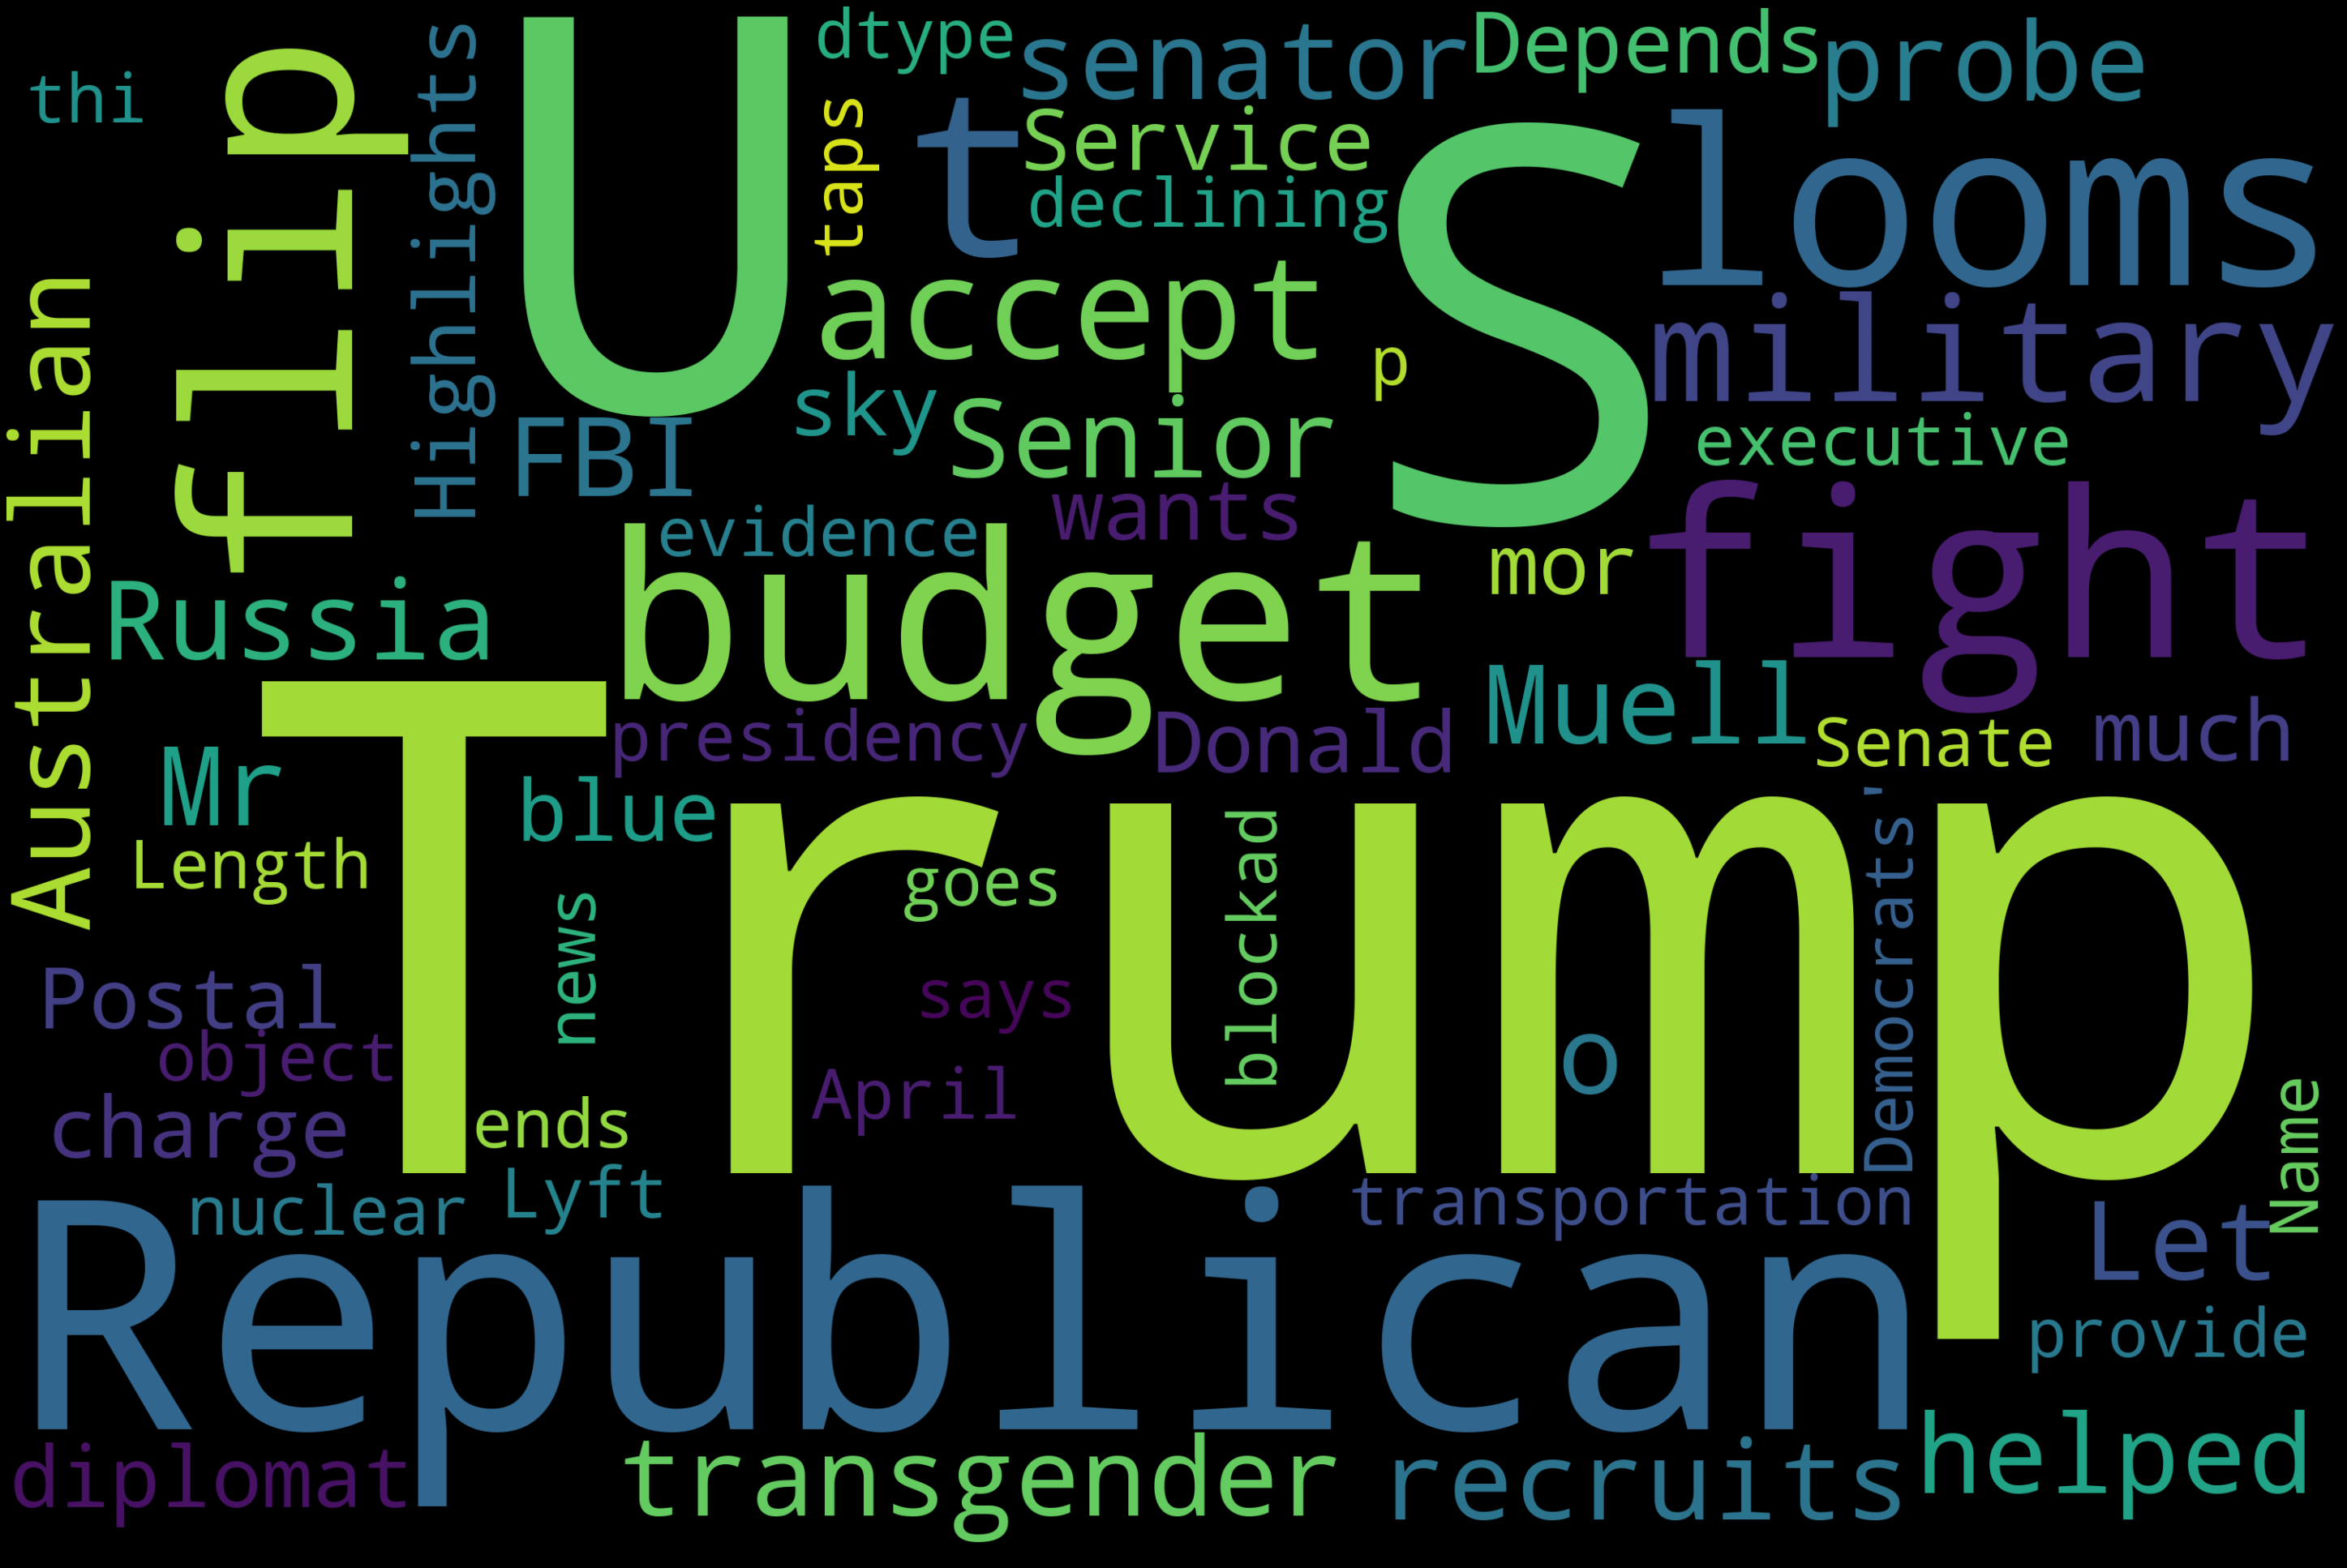

In [ ]:
text = true_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
#Creating the count of output based on date
fake=fake_news.groupby(['date'])['output'].count()
fake=pd.DataFrame(fake)

true=true_news.groupby(['date'])['output'].count()
true=pd.DataFrame(true)

#Plotting the time series graph
fig = go.Figure()
fig.add_trace(go.Scatter(
         x=true.index,
         y=true['output'],
         name='True',
    line=dict(color='blue'),
    opacity=0.8))

fig.add_trace(go.Scatter(
         x=fake.index,
         y=fake['output'],
         name='Fake',
    line=dict(color='red'),
    opacity=0.8))

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
        
    
fig.update_layout(title_text='True and Fake News',plot_bgcolor='rgb(248, 248, 255)',yaxis_title='Value')

fig.show()

In [ ]:
#Extracting 'reviews' for processing
news_features=clean_news.copy()
news_features=news_features[['news']].reset_index(drop=True)
news_features.head()

,news
0,donald trump sends embarrassing new year’s eve...
1,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes internet joke thr...
3,trump obsessed even obama’s name coded website...
4,pope francis called donald trump christmas spe...


In [ ]:
stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)   

In [ ]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like mani us christoph steeledossi prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york timesform trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clintonon top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah elsisi egypt two month elect known former aid set meet world leader trump team trump ran mere coffe boyin may papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt thendemocrat presidenti nomine hillari clinton exactli much mr papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici p

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=2500,ngram_range=(2,2))
X= tfidf_vectorizer.fit_transform(news_features['news'])
X.shape

(7398, 2500)

In [ ]:
#Getting the target variable
y=clean_news['output']

In [ ]:
print(f'Original dataset shape : {Counter(y)}')

Original dataset shape : Counter({1: 4417, 0: 2981})


In [ ]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#creating the objects
from sklearn import svm
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
nb_cv=MultinomialNB(alpha=0.1)
svm = svm.SVC()
#cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'Naive Bayes'}
#cv_models=[logreg_cv,dt_cv,knn_cv,nb_cv,svm]
cv_dict={0:'SVM'}
cv_models = [svm]
#Printing the accuracy
for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

SVM Test Accuracy: 0.9916203415865119


In [ ]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=109.85411419875572, random_state=0)
The mean accuracy of the model is: 0.9951351351351352


In [ ]:
logreg = LogisticRegression(C=24.420530945486497, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


Confusion matrix, without normalization


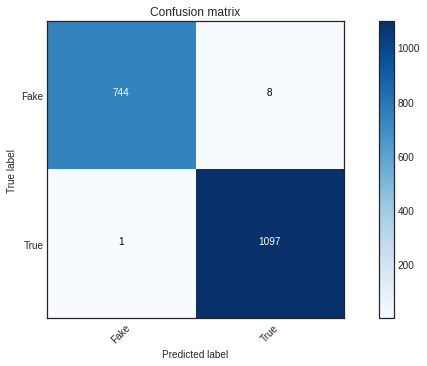

In [ ]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Fake','True'])

In [ ]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       752
           1       0.99      1.00      1.00      1098

    accuracy                           1.00      1850
   macro avg       1.00      0.99      0.99      1850
weighted avg       1.00      1.00      1.00      1850



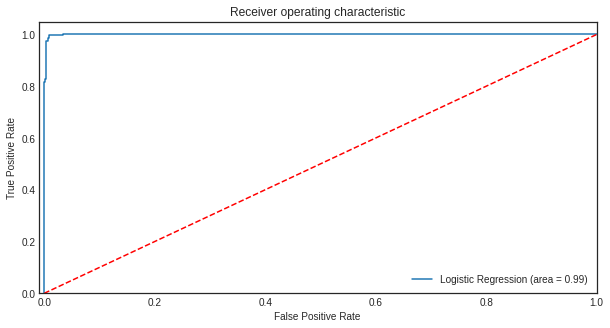

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
corpus[1]

'drunk brag trump staffer start russian collus investigationhous intellig committe chairman devin nune go bad day assumpt like mani us christoph steeledossi prompt russia investig lash depart justic fbi order protect trump happen dossier start investig accord document obtain new york timesform trump campaign advis georg papadopoulo drunk wine bar reveal knowledg russian opposit research hillari clintonon top papadopoulo covfef boy trump administr alleg much larger role none damn drunken fool wine bar coffe boy help arrang new york meet trump presid abdel fattah elsisi egypt two month elect known former aid set meet world leader trump team trump ran mere coffe boyin may papadopoulo reveal australian diplomat alexand downer russian offici shop around possibl dirt thendemocrat presidenti nomine hillari clinton exactli much mr papadopoulo said night kensington wine room australian alexand downer unclear report state two month later leak democrat email began appear onlin australian offici p

In [ ]:
#Setting up vocabulary size
voc_size=10000

#One hot encoding 
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [ ]:
#Setting sentence length
sent_length=5000

#Padding the sentences
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 5898 5984 3092]
 [   0    0    0 ... 3672 5566 3092]
 [   0    0    0 ... 8489 3245 3092]
 ...
 [   0    0    0 ... 7330 1499  228]
 [   0    0    0 ... 6512 2614 1460]
 [   0    0    0 ... 8695 5480 5387]]


In [ ]:
embedded_docs[1]

array([   0,    0,    0, ..., 3672, 5566, 3092], dtype=int32)

In [ ]:
#Creating the lstm model
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100)) #Adding 100 lstm neurons in the layer
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 40)          400000    
                                                                 
 dropout (Dropout)           (None, 5000, 40)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               56400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 456,501
Trainable params: 456,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
len(embedded_docs),y.shape

(7398, (7398,))

In [ ]:
X_final

array([[   0,    0,    0, ..., 5898, 5984, 3092],
       [   0,    0,    0, ..., 3672, 5566, 3092],
       [   0,    0,    0, ..., 8489, 3245, 3092],
       ...,
       [   0,    0,    0, ..., 7330, 1499,  228],
       [   0,    0,    0, ..., 6512, 2614, 1460],
       [   0,    0,    0, ..., 8695, 5480, 5387]], dtype=int32)

In [ ]:
# Converting the X and y as array
X_final=np.array(embedded_docs)
y_final=np.array(y)

#Check shape of X and y final
X_final.shape,y_final.shape

((7398, 5000), (7398,))

In [ ]:
# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Fitting with 10 epochs and 64 batch size
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
78/78 [==============================] - 26s 329ms/step - loss: 0.0172 - accuracy: 0.9964 - val_loss: 0.0275 - val_accuracy: 0.9881
Epoch 2/10
78/78 [==============================] - 23s 302ms/step - loss: 0.0038 - accuracy: 0.9998 - val_loss: 0.0305 - val_accuracy: 0.9894
Epoch 3/10
78/78 [==============================] - 24s 309ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0348 - val_accuracy: 0.9848
Epoch 4/10
78/78 [==============================] - 24s 305ms/step - loss: 7.5184e-04 - accuracy: 0.9998 - val_loss: 0.0242 - val_accuracy: 0.9881
Epoch 5/10
78/78 [==============================] - 28s 366ms/step - loss: 4.5289e-04 - accuracy: 1.0000 - val_loss: 0.0411 - val_accuracy: 0.9844
Epoch 6/10
78/78 [==============================] - 27s 346ms/step - loss: 0.0071 - accuracy: 0.9992 - val_loss: 0.0199 - val_accuracy: 0.9943
Epoch 7/10
78/78 [==============================] - 24s 310ms/step - loss: 9.2369e-04 - accuracy: 1.0000 - val_loss: 0.0161 - val_accu

In [ ]:
# Predicting from test data
X_test
y_pred=model.predict(X_test)
y_pred
#Creating confusion matrix
#confusion_matrix(y_test,y_pred)
#cm = metrics.confusion_matrix(y_test, y_pred)
#plot_confusion_matrix(cm,classes=['Fake','True'])

77/77 [==============================] - 6s 74ms/step


array([[8.2263296e-06],
       [9.9995267e-01],
       [6.1735182e-06],
       ...,
       [6.7553146e-06],
       [9.8189257e-06],
       [9.9984241e-01]], dtype=float32)

In [ ]:
len(X_test[0])

In [ ]:
yout = model.predict(X_test[0])
yout

InvalidArgumentError: ignored

In [ ]:
#Checking for accuracy
#accuracy_score(y_test,y_pred)
print(y_test[1:])
print(y_pred)

In [ ]:
# Creating bidirectional lstm model
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100))) # Bidirectional LSTM layer
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

In [ ]:
# Fitting the model
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

In [ ]:
# Predicting from test dataset
y_pred1=model1.predict(X_test)
model1.save
#Confusion matrix
#cm = metrics.confusion_matrix(y_test, y_pred1)
#plot_confusion_matrix(cm,classes=['Fake','True'])

In [ ]:
#Calculating Accuracy score
#accuracy_score(y_test,y_pred1)

In [ ]:
# Creating classification report 
#print(classification_report(y_test,y_pred1))

In [ ]:
model_json = model1.to_json()
with open("/content/drive/MyDrive/FinalModel/model1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("/content/drive/MyDrive/FinalModel/model1.h5")

In [ ]:
X_test

In [ ]:
type(corpus)

list